In [ ]:
!pip3 install librosa

In [66]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [43]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [44]:
#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

In [45]:
df = pd.DataFrame(raw)
df = df[:100]
print(df.shape)
df.head()

(100, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


## Preprocessing and Feuture Extraction

* We split the dataset as 70% train and 30% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [46]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (70, 2), Test set size (30, 2)


True

In [47]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [48]:
# extract Zero Crossing Rate
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

In [49]:
df_train.head()

,speaker,path,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-196.19745, 96.77209, -9.442002, 22.09873, -2...","[-0.29390892, -0.18999796, -0.014305613, 0.165...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-385.69135, 122.257576, -14.257886, -23.04002...","[0.08598741, -0.07328853, 0.024153156, 0.01808...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-223.81839, 86.769295, -17.60496, 23.541613, ...","[-0.16981685, 0.023842582, 0.12981227, 0.07679...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-159.21338, 96.507286, -21.005232, 2.2055504,...","[-0.1431608, 0.0911606, 0.027648797, 0.0220658...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-204.95496, 92.93275, -16.543903, 7.745483, 2...","[-0.039691795, 0.113837615, -0.073666826, -0.0...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [50]:
df_test.head()

,speaker,path,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-196.19745, 96.77209, -9.442002, 22.09873, -2...","[-0.29390892, -0.18999796, -0.014305613, 0.165...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-385.69135, 122.257576, -14.257886, -23.04002...","[0.08598741, -0.07328853, 0.024153156, 0.01808...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-223.81839, 86.769295, -17.60496, 23.541613, ...","[-0.16981685, 0.023842582, 0.12981227, 0.07679...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-159.21338, 96.507286, -21.005232, 2.2055504,...","[-0.1431608, 0.0911606, 0.027648797, 0.0220658...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-204.95496, 92.93275, -16.543903, 7.745483, 2...","[-0.039691795, 0.113837615, -0.073666826, -0.0...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [51]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,2:5]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 2
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (49, 39), Validation set size (21, 39)


## Deep Learning Model

In [52]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               4000      
_________________________________________________________________
activation_8 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_9 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)              

In [53]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 8


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
7/7 [==============================] - 1s 30ms/step - loss: 20.1133 - accuracy: 0.5306 - val_loss: 3.0662 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 3.06619, saving model to saved_models/speakers_classification.hdf5
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 15.3738 - accuracy: 0.4082 - val_loss: 8.3207 - val_accuracy: 0.1905

Epoch 00002: val_loss did not improve from 3.06619
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 18.2419 - accuracy: 0.4898 - val_loss: 13.1057 - val_accuracy: 0.1905

Epoch 00003: val_loss did not improve from 3.06619
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 10.7907 - accuracy: 0.5918 - val_loss: 5.5089 - val_accuracy: 0.2381

Epoch 00004: val_loss did not improve from 3.06619
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 8.7913 - accuracy: 0.5510 - val_loss: 2.2059 - val_accuracy: 0.5714

Epoch 00005: val_loss improved 

7/7 [==============================] - 0s 15ms/step - loss: 1.1258 - accuracy: 0.6735 - val_loss: 0.4774 - val_accuracy: 0.6667

Epoch 00042: val_loss did not improve from 0.47425
Epoch 43/200
7/7 [==============================] - 0s 18ms/step - loss: 3.6730 - accuracy: 0.5510 - val_loss: 0.4770 - val_accuracy: 0.6667

Epoch 00043: val_loss did not improve from 0.47425
Epoch 44/200
7/7 [==============================] - 0s 13ms/step - loss: 1.9694 - accuracy: 0.6735 - val_loss: 0.5893 - val_accuracy: 0.6667

Epoch 00044: val_loss did not improve from 0.47425
Epoch 45/200
7/7 [==============================] - 0s 18ms/step - loss: 2.4169 - accuracy: 0.6122 - val_loss: 0.5947 - val_accuracy: 0.6667

Epoch 00045: val_loss did not improve from 0.47425
Epoch 46/200
7/7 [==============================] - 0s 17ms/step - loss: 2.3531 - accuracy: 0.6327 - val_loss: 0.6603 - val_accuracy: 0.6667

Epoch 00046: val_loss did not improve from 0.47425
Epoch 47/200
7/7 [==============================

### Check training history

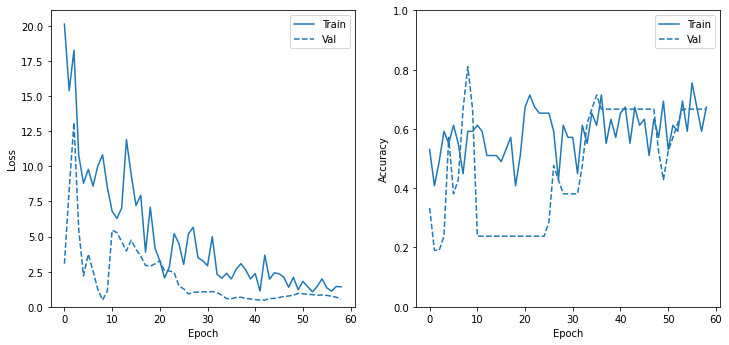

In [54]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [55]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(30, 39)
['id10009' 'id10007' 'id10009' 'id10009' 'id10009' 'id10009' 'id10009'
 'id10009' 'id10009' 'id10009' 'id10009' 'id10007' 'id10009' 'id10009'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10009' 'id10007' 'id10007'
 'id10009' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007']
              precision    recall  f1-score   support

     id10007       0.62      0.83      0.71        12
     id10009       0.86      0.67      0.75        18

    accuracy                           0.73        30
   macro avg       0.74      0.75      0.73        30
weighted avg       0.76      0.73      0.74        30



In [ ]:
# clip = '/Users/vpapadop/Documents/GitHub/speaker-similarity/vox_dev_wav/wav/id10001/1zcIwhmdeo4/00001.wav'
# tmp = pd.DataFrame()
# tmp[['mfcc', 'delta']] = extract_mfcc(clip,20)
# X_tmp = np.hstack((tmp['mfcc'].to_list(),tmp['delta'].to_list()))
# X_tmp = np.expand_dims(X_tmp, axis=0)
# print(X_tmp.shape)

# y_pred = model.predict(X_tmp)
# print(y_pred)

## Gausian Mixture Model

In [68]:
from sklearn import mixture
# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X_train)

y_true_gmm = df_test['speaker']

y_pred_gmm = gmm.predict(X_test)
y_pred_gmm = le.classes_[y_pred_gmm]
print(y_pred_gmm)
print(classification_report(y_true_gmm, y_pred_gmm, target_names=le.classes_))

filename = 'saved_models/gaussian_mixture_model.sav'
pickle.dump(gmm, open(filename, 'wb'))


# # display predicted scores by the model as a contour plot
# x = np.linspace(0., 39., 39, endpoint=True)
# # np.linspace(0, 10, N, endpoint=True)
# y = np.linspace(0., 39., 39, endpoint=True)
# X, Y = np.meshgrid(x, y)
# XX = np.array([X.ravel(), Y.ravel()]).T
# Z = -clf.score_samples(XX)
# Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 10))
# CB = plt.colorbar(CS, shrink=0.8, extend='both')
# plt.scatter(X_train[:, 0], X_train[:, 1], .8)

# plt.title('Negative log-likelihood predicted by a GMM')
# plt.axis('tight')
# plt.show()


['id10009' 'id10009' 'id10009' 'id10009' 'id10009' 'id10009' 'id10009'
 'id10009' 'id10009' 'id10009' 'id10009' 'id10007' 'id10009' 'id10009'
 'id10009' 'id10009' 'id10007' 'id10009' 'id10009' 'id10009' 'id10009'
 'id10009' 'id10007' 'id10009' 'id10009' 'id10009' 'id10009' 'id10007'
 'id10009' 'id10009']
              precision    recall  f1-score   support

     id10007       0.50      0.17      0.25        12
     id10009       0.62      0.89      0.73        18

    accuracy                           0.60        30
   macro avg       0.56      0.53      0.49        30
weighted avg       0.57      0.60      0.54        30



In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)